In [7]:
## import pandas as pd
import numpy as np
from sklearn import metrics, preprocessing, linear_model
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import PredefinedSplit
import random
from sklearn.model_selection import KFold
# Set seed for reproducibility
np.random.seed(0)

In [2]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [3]:
print("# Loading data...")
# The training data is used to train your model how to predict the targets.
train = pd.read_csv('numerai_training_data.csv', header=0)
# The tournament data is the data that Numerai uses to evaluate your model.
tournament = pd.read_csv('numerai_tournament_data.csv', header=0)

# The tournament data contains validation data, test data and live data.
# Validation is used to test your model locally so we separate that.
validation = tournament[tournament['data_type']=='validation']
test = tournament[tournament['data_type']=='test']
# There are five targets in the training data which you can choose to model using the features.
# Numerai does not say what the features mean but that's fine; we can still build a model.
# Here we select the bernie_target.
train_bernie = train.drop(['id', 'era', 'data_type',
        'target_charles', 'target_elizabeth',
        'target_jordan', 'target_ken'], axis=1)
features = [f for f in list(train_bernie) if "feature" in f]
X = train_bernie[features]
X_valid=validation[features]
Y = train_bernie['target_bernie']
Y_valid = validation['target_bernie']

# Loading data...


24


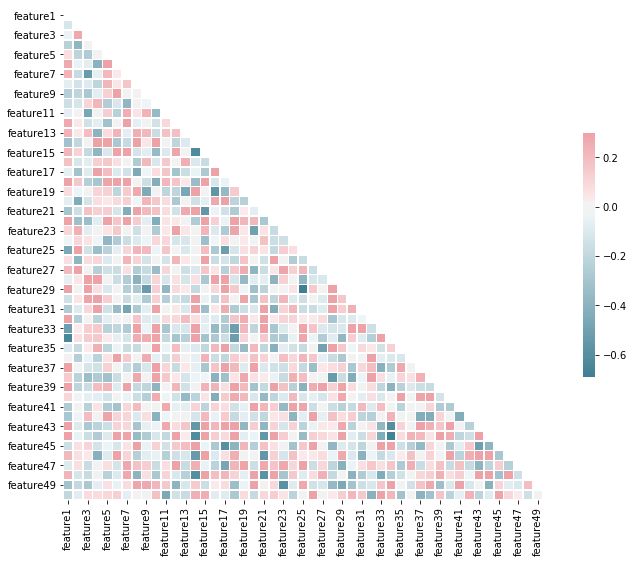

In [4]:
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

print(len(np.where(np.abs(corr.values)>0.6)[0])-50)
(f1,f2)=np.where(np.abs(corr.values)>0.693)

In [5]:
(f1,f2)=np.where(np.abs(corr.values)>0.5)
added=[]
for first,second in tqdm(zip(f1,f2)):
    
    if first!=second:
            #print(first,second)
            X["feature"+str(first+1)+'**'+str(second+1)]=X["feature"+str(first+1)]**X["feature"+str(second+1)]
            X_valid["feature"+str(first+1)+'**'+str(second+1)]=X_valid["feature"+str(first+1)]**X_valid["feature"+str(second+1)]
            X["feature"+str(first+1)+'_'+str(second+1)]=X["feature"+str(first+1)]/X["feature"+str(second+1)]
            X_valid["feature"+str(first+1)+'_'+str(second+1)]=X_valid["feature"+str(first+1)]/X_valid["feature"+str(second+1)]
            X["feature"+str(first+1)+'_l_'+str(second+1)]=np.log(X["feature"+str(first+1)])/np.log(X["feature"+str(second+1)])
            X_valid["feature"+str(first+1)+'_l_'+str(second+1)]=np.log(X_valid["feature"+str(first+1)])/np.log(X_valid["feature"+str(second+1)])

X=X.replace(np.inf,100)
X_valid=X_valid.replace(np.inf,100)
X=X.replace(-np.inf,100)
X_valid=X_valid.replace(-np.inf,100)
X=X.fillna(100)
X_valid=X_valid.fillna(100)

134it [00:03, 34.22it/s]


In [9]:
#spajanje i kfold
X_tot=X.append(X_valid)
Y_tot=Y.append(Y_valid)
xgb_mod=[]
dubina=[3,4,5]
gamma=[0.1,0.2,0.05]
stabla=[100,800,900,1000]


X_tot=X_tot.values
Y_tot=Y_tot.values

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X_tot):
    
    X_train, X_test = X_tot[train_index], X_tot[test_index]
    Y_train, Y_test = Y_tot[train_index], Y_tot[test_index]

    model=XGBClassifier(nthread = 4,max_depth= random.choice(dubina),silent=False, \
                  n_estimators= random.choice(stabla), gamma=random.choice(gamma), subsample = 0.5 )
    model.fit(X_train,Y_train,eval_set= [[X_test, Y_test]],eval_metric="logloss",early_stopping_rounds=10)
    xgb_mod.append(model)

[0]	validation_0-logloss:0.693066
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.693005
[2]	validation_0-logloss:0.692946
[3]	validation_0-logloss:0.692888
[4]	validation_0-logloss:0.692818
[5]	validation_0-logloss:0.692792
[6]	validation_0-logloss:0.692769
[7]	validation_0-logloss:0.692769
[8]	validation_0-logloss:0.692788
[9]	validation_0-logloss:0.692779
[10]	validation_0-logloss:0.692753
[11]	validation_0-logloss:0.692727
[12]	validation_0-logloss:0.692704
[13]	validation_0-logloss:0.692689
[14]	validation_0-logloss:0.692691
[15]	validation_0-logloss:0.692683
[16]	validation_0-logloss:0.692683
[17]	validation_0-logloss:0.692713
[18]	validation_0-logloss:0.69272
[19]	validation_0-logloss:0.692707
[20]	validation_0-logloss:0.692698
[21]	validation_0-logloss:0.692673
[22]	validation_0-logloss:0.692684
[23]	validation_0-logloss:0.692679
[24]	validation_0-logloss:0.692669
[25]	validation_0-logloss:0.692694
[26]	validation_0-logloss:0.69269

In [32]:
np.shape(X_tot)[1]

302

In [10]:
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
nn_mod=[]
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X_tot):
    # this is our input placeholder
    X_train, X_test = X_tot[train_index], X_tot[test_index]
    Y_train, Y_test = Y_tot[train_index], Y_tot[test_index]
    input_data = Input(shape=(np.shape(X_tot)[1],))
    # "encoded" is the encoded representation of the input
    x= Dense(64, activation='relu')(input_data)
    x = Dense(32, activation='relu')(x)
    if np.random.uniform()>0.4:
        x = Dropout(0.3)(x)
        x = Dense(32, activation='relu')(x)
        x= Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    if np.random.uniform()>0.2:
        x= Dense(16, activation='relu')(x)
        x= Dense(16, activation='relu')(x)
        x = Dropout(0.25)(x)
    x= Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    x= Dense(4, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    # this model maps an input to its reconstruction
    nn = Model(input_data, output)

    nn.compile(optimizer=Adam(lr=0.0003), loss='binary_crossentropy')
    
    es=EarlyStopping(monitor='val_loss',min_delta=0,patience=8, verbose=2, mode='auto',restore_best_weights=True)
    nn.fit(X_train, Y_train,epochs=50,
                batch_size=256,
                shuffle=True, verbose=2,
                validation_data=(X_test, Y_test),callbacks=[es])
    nn_mod.append(nn)

Train on 351980 samples, validate on 87995 samples
Epoch 1/50
 - 4s - loss: 0.6932 - val_loss: 0.6931
Epoch 2/50
 - 4s - loss: 0.6931 - val_loss: 0.6930
Epoch 3/50
 - 4s - loss: 0.6931 - val_loss: 0.6931
Epoch 4/50
 - 4s - loss: 0.6930 - val_loss: 0.6929
Epoch 5/50
 - 4s - loss: 0.6929 - val_loss: 0.6927
Epoch 6/50
 - 4s - loss: 0.6928 - val_loss: 0.6927
Epoch 7/50
 - 4s - loss: 0.6928 - val_loss: 0.6926
Epoch 8/50
 - 4s - loss: 0.6927 - val_loss: 0.6926
Epoch 9/50
 - 4s - loss: 0.6928 - val_loss: 0.6927
Epoch 10/50
 - 4s - loss: 0.6927 - val_loss: 0.6926
Epoch 11/50
 - 4s - loss: 0.6927 - val_loss: 0.6926
Epoch 12/50
 - 4s - loss: 0.6927 - val_loss: 0.6928
Epoch 13/50
 - 4s - loss: 0.6927 - val_loss: 0.6926
Epoch 14/50
 - 4s - loss: 0.6926 - val_loss: 0.6925
Epoch 15/50
 - 4s - loss: 0.6926 - val_loss: 0.6927
Epoch 16/50
 - 4s - loss: 0.6926 - val_loss: 0.6927
Epoch 17/50
 - 4s - loss: 0.6926 - val_loss: 0.6925
Epoch 18/50
 - 4s - loss: 0.6926 - val_loss: 0.6924
Epoch 19/50
 - 4s - lo

In [11]:
X_train, X_test = X_tot[train_index], X_tot[test_index]
Y_train, Y_test = Y_tot[train_index], Y_tot[test_index]
input_data = Input(shape=(np.shape(X_tot)[1],))
# "encoded" is the encoded representation of the input
x= Dense(128, activation='relu')(input_data)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x= Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)

x= Dense(16, activation='relu')(x)
x= Dense(16, activation='relu')(x)
x = Dropout(0.25)(x)
x= Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
x= Dense(4, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# this model maps an input to its reconstruction
nn = Model(input_data, output)

nn.compile(optimizer=Adam(lr=0.0003), loss='binary_crossentropy')
nn.fit(X_train, Y_train,epochs=50,
            batch_size=256,
            shuffle=True, verbose=2,
            validation_data=(X_test, Y_test))


Train on 351980 samples, validate on 87995 samples
Epoch 1/50
 - 7s - loss: 0.6932 - val_loss: 0.6931
Epoch 2/50
 - 5s - loss: 0.6931 - val_loss: 0.6931
Epoch 3/50
 - 6s - loss: 0.6932 - val_loss: 0.6931
Epoch 4/50
 - 6s - loss: 0.6932 - val_loss: 0.6931
Epoch 5/50
 - 7s - loss: 0.6932 - val_loss: 0.6932
Epoch 6/50
 - 7s - loss: 0.6931 - val_loss: 0.6931
Epoch 7/50
 - 6s - loss: 0.6932 - val_loss: 0.6931
Epoch 8/50
 - 6s - loss: 0.6932 - val_loss: 0.6931
Epoch 9/50
 - 6s - loss: 0.6932 - val_loss: 0.6931
Epoch 10/50
 - 6s - loss: 0.6932 - val_loss: 0.6931
Epoch 11/50
 - 7s - loss: 0.6932 - val_loss: 0.6931
Epoch 12/50
 - 7s - loss: 0.6932 - val_loss: 0.6931
Epoch 13/50
 - 6s - loss: 0.6932 - val_loss: 0.6931
Epoch 14/50
 - 6s - loss: 0.6931 - val_loss: 0.6932
Epoch 15/50
 - 6s - loss: 0.6931 - val_loss: 0.6929
Epoch 16/50
 - 6s - loss: 0.6930 - val_loss: 0.6929
Epoch 17/50
 - 6s - loss: 0.6930 - val_loss: 0.6927
Epoch 18/50
 - 6s - loss: 0.6928 - val_loss: 0.6928
Epoch 19/50
 - 6s - lo

In [16]:
X_stack=pd.DataFrame(X_tot)
for i,mod in enumerate(xgb_mod):
    temp=mod.predict_proba(X_tot)
    X_stack["XGB_"+str(i)]=temp[:,1]
for i,mod in enumerate(nn_mod):
    temp=mod.predict(X_tot)
    X_stack["NN_"+str(i)]=temp

In [17]:
dubina=[3,4,5]
gamma=[0.1,0.2,0.05]
stabla=[100,800,900,1000]

xgb_lvl2=[]

X_stack=X_stack.values

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X_tot):
    
    X_train, X_test = X_stack[train_index], X_stack[test_index]
    Y_train, Y_test = Y_tot[train_index], Y_tot[test_index]

    model=XGBClassifier(nthread = 4,max_depth= random.choice(dubina),silent=False, \
                  n_estimators= random.choice(stabla), gamma=random.choice(gamma), subsample = 0.5 )
    model.fit(X_train,Y_train,eval_set= [[X_test, Y_test]],eval_metric="logloss",early_stopping_rounds=10)
    xgb_lvl2.append(model)

[0]	validation_0-logloss:0.692788
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.69261
[2]	validation_0-logloss:0.692369
[3]	validation_0-logloss:0.691987
[4]	validation_0-logloss:0.691753
[5]	validation_0-logloss:0.69164
[6]	validation_0-logloss:0.691716
[7]	validation_0-logloss:0.691652
[8]	validation_0-logloss:0.691703
[9]	validation_0-logloss:0.691451
[10]	validation_0-logloss:0.691445
[11]	validation_0-logloss:0.691326
[12]	validation_0-logloss:0.691236
[13]	validation_0-logloss:0.691289
[14]	validation_0-logloss:0.691313
[15]	validation_0-logloss:0.691225
[16]	validation_0-logloss:0.691226
[17]	validation_0-logloss:0.6912
[18]	validation_0-logloss:0.691081
[19]	validation_0-logloss:0.690998
[20]	validation_0-logloss:0.690949
[21]	validation_0-logloss:0.691033
[22]	validation_0-logloss:0.691108
[23]	validation_0-logloss:0.691095
[24]	validation_0-logloss:0.691067
[25]	validation_0-logloss:0.690975
[26]	validation_0-logloss:0.690957
[

[0]	validation_0-logloss:0.692341
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.691734
[2]	validation_0-logloss:0.691155
[3]	validation_0-logloss:0.690864
[4]	validation_0-logloss:0.690429
[5]	validation_0-logloss:0.690151
[6]	validation_0-logloss:0.689828
[7]	validation_0-logloss:0.689707
[8]	validation_0-logloss:0.689486
[9]	validation_0-logloss:0.689295
[10]	validation_0-logloss:0.689125
[11]	validation_0-logloss:0.688938
[12]	validation_0-logloss:0.688777
[13]	validation_0-logloss:0.688595
[14]	validation_0-logloss:0.688466
[15]	validation_0-logloss:0.688346
[16]	validation_0-logloss:0.688321
[17]	validation_0-logloss:0.688311
[18]	validation_0-logloss:0.688209
[19]	validation_0-logloss:0.688159
[20]	validation_0-logloss:0.688061
[21]	validation_0-logloss:0.687986
[22]	validation_0-logloss:0.687892
[23]	validation_0-logloss:0.68784
[24]	validation_0-logloss:0.687775
[25]	validation_0-logloss:0.687764
[26]	validation_0-logloss:0.68767

In [27]:
rj=pd.DataFrame(Y_tot,columns=["Org"])
for i,mod in enumerate(xgb_lvl2):
    out=mod.predict_proba(X_stack)[:,1]
    rj["mod"+str(i)]=out

In [37]:

pr=rj["mod0"].values
for i in range(1,4):
    pr=pr+rj["mod"+str(i)].values
pr=pr/4

pr[np.where(pr<0.45)]=pr[np.where(pr<0.45)]*0.85
pr[np.where(pr>0.55)]=pr[np.where(pr>0.55)]*1.15
print("- validation logloss:", metrics.log_loss(Y_tot, pr))

- validation logloss: 0.6826175625637598


(array([2.0000e+00, 1.2000e+01, 1.1000e+01, 3.7000e+01, 6.0000e+01,
        9.0000e+01, 1.6700e+02, 3.0100e+02, 4.7100e+02, 7.6800e+02,
        1.1880e+03, 1.9750e+03, 3.0870e+03, 4.6770e+03, 7.3820e+03,
        1.1653e+04, 1.8985e+04, 2.9718e+04, 4.5783e+04, 6.5136e+04,
        7.2637e+04, 6.2016e+04, 4.5792e+04, 3.0641e+04, 1.7683e+04,
        8.8550e+03, 4.4090e+03, 2.5440e+03, 1.4390e+03, 8.7600e+02,
        5.3600e+02, 4.3200e+02, 2.5000e+02, 1.5600e+02, 9.3000e+01,
        5.0000e+01, 2.7000e+01, 2.3000e+01, 8.0000e+00, 5.0000e+00]),
 array([0.2195905 , 0.23341869, 0.24724688, 0.26107507, 0.27490326,
        0.28873145, 0.30255964, 0.31638783, 0.33021601, 0.3440442 ,
        0.35787239, 0.37170058, 0.38552877, 0.39935696, 0.41318515,
        0.42701334, 0.44084153, 0.45466972, 0.46849791, 0.4823261 ,
        0.49615429, 0.50998248, 0.52381066, 0.53763885, 0.55146704,
        0.56529523, 0.57912342, 0.59295161, 0.6067798 , 0.62060799,
        0.63443618, 0.64826437, 0.66209256, 0.

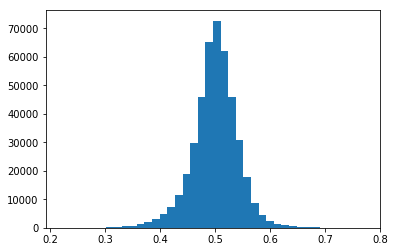

In [34]:
results=pr[len(X):]
results_df = pd.DataFrame(data={'probability':results})
joined = pd.DataFrame(ids).join(results_df)
print("- joined:", joined.head())

print("# Writing predictions to bernie_submissions.csv...")
# Save the predictions out to a CSV file.
joined.to_csv("bernie_submission.csv", index=False)

In [41]:
#tournament = pd.read_csv('numerai_tournament_data.csv', header=0)
tournament[tournament['data_type']=='live'].head()

id   era data_type  feature1  feature2  feature3  \
238967  n8e02294f3dbe483  eraX      live   0.42823   0.54526   0.52383   
238968  nda916c276f4c4fa  eraX      live   0.40934   0.34531   0.47357   
238969  n09434bec8e314c6  eraX      live   0.28581   0.55702   0.59125   
238970  n631fa16d1ebb45b  eraX      live   0.51084   0.47148   0.50340   
238971  nc4d6d24e055f437  eraX      live   0.41508   0.48472   0.50571   

        feature4  feature5  feature6  feature7     ...      feature46  \
238967   0.51759   0.56087   0.49724   0.65700     ...        0.41622   
238968   0.56686   0.67092   0.45522   0.60851     ...        0.45463   
238969   0.54601   0.55935   0.46735   0.49763     ...        0.32409   
238970   0.38080   0.61388   0.61315   0.54164     ...        0.50467   
238971   0.62118   0.47280   0.31426   0.47666     ...        0.52188   

        feature47  feature48  feature49  feature50  target_bernie  \
238967    0.58342    0.40102    0.42519    0.59330            NaN   
238968    0.66168    0.34431    0.38650    0.68032            NaN   
238969    0.62225    0.36375    0.38558    0.50792            NaN   
238970    0.45973    0.54354    0.53336    0.57013            NaN   
238971    0.53987    0.64705    0.56493    0.78174            NaN   

        target_charles  target_elizabeth  target_jordan  target_ken  
238967             NaN               NaN            NaN         NaN  
238968             NaN               NaN            NaN         NaN  
238969             NaN               NaN            NaN         NaN  
238970             NaN               NaN            NaN         NaN  
238971             NaN               NaN            NaN         NaN  

[5 rows x 58 columns]

In [ ]:
params = {
        'learning_rate': [0.03,0.3,0.7],
        'min_child_weight': [0.01,0.5,1, 5],
        'gamma': [0,0.05, 0.5, 2],
        'subsample': [0.3, 0.8, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 4, 6,8],
        'reg_lambda':[0,0.5,1,2],
        'reg_alpha':[0,0.5,1,2],
        }
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
folds = 3
param_comb = 700


fit_params={"early_stopping_rounds":10, 
            "eval_metric" : "logloss", 
            "eval_set" : [[X_valid, Y_valid]]}

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, \
                                   fit_params=fit_params,cv=skf.split(X,Y), verbose=10, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, Y)
timer(start_time) # timing ends here for "start_time" variable


print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)



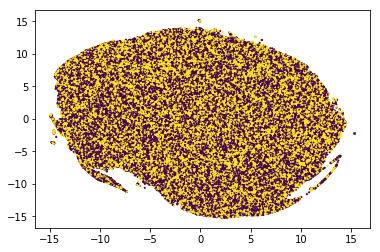

In [10]:
from MulticoreTSNE import MulticoreTSNE as TSNE

#tsne = TSNE(n_jobs=4,verbose=10)
#X_embedded= tsne.fit_transform(X)

plt.scatter(X_embedded[:,0],X_embedded[:,1],c=Y,s=1)

In [11]:
X['tsneX']=X_embedded[:,0]
X['tsneY']=X_embedded[:,1]

temp=tsne.transfrom(X_valid)
X_valid['tsneX']=temp[:,0]
X_valid['tsneY']=temp[:,1]

AttributeError: 'MulticoreTSNE' object has no attribute 'transfrom'

In [24]:
len(list(X))

89

In [165]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 16  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(len(list(X)),))
# "encoded" is the encoded representation of the input
encoded = Dense(64, activation='relu')(input_img)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(len(list(X)), activation='linear')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
# create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.fit(X, X,verbose=2,
                epochs=50,
                batch_size=256,
               shuffle=True,
              validation_data=(X_valid, X_valid))

Train on 393613 samples, validate on 46362 samples
Epoch 1/50
 - 16s - loss: 0.2917 - val_loss: 0.1680
Epoch 2/50
 - 16s - loss: 0.2148 - val_loss: 0.1485
Epoch 3/50
 - 16s - loss: 0.1845 - val_loss: 0.1334
Epoch 4/50
 - 16s - loss: 0.1667 - val_loss: 0.1181
Epoch 5/50
 - 15s - loss: 0.1501 - val_loss: 0.1104
Epoch 6/50
 - 16s - loss: 0.1374 - val_loss: 0.1033
Epoch 7/50
 - 16s - loss: 0.1282 - val_loss: 0.0949
Epoch 8/50
 - 16s - loss: 0.1261 - val_loss: 0.0953
Epoch 9/50
 - 16s - loss: 0.1175 - val_loss: 0.0884
Epoch 10/50
 - 17s - loss: 0.1118 - val_loss: 0.0874
Epoch 11/50
 - 16s - loss: 0.1086 - val_loss: 0.0893
Epoch 12/50
 - 17s - loss: 0.1059 - val_loss: 0.0818
Epoch 13/50
 - 16s - loss: 0.1009 - val_loss: 0.1157
Epoch 14/50
 - 16s - loss: 0.0977 - val_loss: 0.0852
Epoch 15/50
 - 17s - loss: 0.0967 - val_loss: 0.0772
Epoch 16/50
 - 16s - loss: 0.0932 - val_loss: 0.0752
Epoch 17/50
 - 17s - loss: 0.0889 - val_loss: 0.0716
Epoch 18/50
 - 16s - loss: 0.0851 - val_loss: 0.0728
Epoc

In [166]:
X2=encoder.predict(X)
X2_valid=encoder.predict(X_valid)

In [167]:
param = {'max_depth': 4, 'eta': 0.1, 'objective': 'binary:logistic','silent':False, 'n_estimators': 1000, 'gamma':0.3, \
          'subsample':0.5,'booster':'gbtree'}
param['nthread'] = 4
param['eval_metric'] = 'logloss'
num_round = 1000
model=XGBClassifier(param=param)

model.fit(X2,Y,eval_set= [[X2_valid, Y_valid]],eval_metric="logloss",early_stopping_rounds=10,  )
#bst = xgb.train(param, dtrain, num_round,[(dtrain,'train'),(dvalid,'test')], early_stopping_rounds=10)

[0]	validation_0-logloss:0.693032
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.692946
[2]	validation_0-logloss:0.692867
[3]	validation_0-logloss:0.692814
[4]	validation_0-logloss:0.692757
[5]	validation_0-logloss:0.692716
[6]	validation_0-logloss:0.692682
[7]	validation_0-logloss:0.692641
[8]	validation_0-logloss:0.692621
[9]	validation_0-logloss:0.692595
[10]	validation_0-logloss:0.692572
[11]	validation_0-logloss:0.692556
[12]	validation_0-logloss:0.69254
[13]	validation_0-logloss:0.692531
[14]	validation_0-logloss:0.692513
[15]	validation_0-logloss:0.692496
[16]	validation_0-logloss:0.692503
[17]	validation_0-logloss:0.692488
[18]	validation_0-logloss:0.692472
[19]	validation_0-logloss:0.692458
[20]	validation_0-logloss:0.692457
[21]	validation_0-logloss:0.69243
[22]	validation_0-logloss:0.692435
[23]	validation_0-logloss:0.692429
[24]	validation_0-logloss:0.69243
[25]	validation_0-logloss:0.692425
[26]	validation_0-logloss:0.692434


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       param={'max_depth': 4, 'eta': 0.1, 'objective': 'binary:logistic', 'silent': False, 'n_estimators': 1000, 'gamma': 0.3, 'subsample': 0.5, 'booster': 'gbtree', 'nthread': 4, 'eval_metric': 'logloss'},
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [164]:
from keras.optimizers import Adam
from keras.layers import Dropout
# this is our input placeholder
input_data = Input(shape=(len(list(X)),))
# "encoded" is the encoded representation of the input
x= Dense(64, activation='relu')(input_data)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x= Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)
x= Dense(16, activation='relu')(x)
x= Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)
x= Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
x= Dense(4, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# this model maps an input to its reconstruction
nn = Model(input_data, output)

nn.compile(optimizer=Adam(lr=0.0003), loss='binary_crossentropy')
nn.fit(X, Y,epochs=50,
            batch_size=256,
            shuffle=True, verbose=2,
            validation_data=(X_valid, Y_valid))

Train on 393613 samples, validate on 46362 samples
Epoch 1/50
 - 12s - loss: 0.6932 - val_loss: 0.6931
Epoch 2/50
 - 11s - loss: 0.6932 - val_loss: 0.6931
Epoch 3/50
 - 11s - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
 - 11s - loss: 0.6931 - val_loss: 0.6928
Epoch 5/50
 - 10s - loss: 0.6929 - val_loss: 0.6928
Epoch 6/50
 - 10s - loss: 0.6928 - val_loss: 0.6926
Epoch 7/50
 - 10s - loss: 0.6928 - val_loss: 0.6928
Epoch 8/50
 - 10s - loss: 0.6927 - val_loss: 0.6926
Epoch 9/50
 - 11s - loss: 0.6927 - val_loss: 0.6925
Epoch 10/50
 - 10s - loss: 0.6927 - val_loss: 0.6926
Epoch 11/50
 - 10s - loss: 0.6927 - val_loss: 0.6925
Epoch 12/50
 - 11s - loss: 0.6926 - val_loss: 0.6925
Epoch 13/50
 - 11s - loss: 0.6926 - val_loss: 0.6925
Epoch 14/50
 - 10s - loss: 0.6926 - val_loss: 0.6928
Epoch 15/50
 - 10s - loss: 0.6926 - val_loss: 0.6926
Epoch 16/50
 - 10s - loss: 0.6925 - val_loss: 0.6927
Epoch 17/50
 - 11s - loss: 0.6925 - val_loss: 0.6930
Epoch 18/50
 - 11s - loss: 0.6925 - val_loss: 0.6925
Epoc

In [177]:
out_nn=nn.predict(X)
out_nn=np.reshape(out_nn,(-1))
out_xgb=model.predict_proba(X2)[:,1]

out_nn_valid=nn.predict(X_valid)
out_nn_valid=np.reshape(out_nn_valid,(-1))
out_xgb_valid=model.predict_proba(X2_valid)[:,1]

In [104]:
tr=0.5
prob=np.zeros_like(Y_valid)-1
prob[(out_xgb>tr) & (out_nn>tr)]=np.max((out_nn[(out_xgb>tr) & (out_nn>tr)],out_xgb[(out_xgb>tr) & (out_nn>tr)]))
#prob[(out_xgb==1) & (out_nn<tr)]=0
#prob[(out_xgb==0) & (out_nn>tr)]=1
#prob[(out_xgb<tr) & (out_nn<tr)]=np.min((out_nn[(out_xgb<tr) & (out_nn<tr)],out_xgb[(out_xgb<tr) & (out_nn<tr)]))
prob=(out_nn+out_xgb)/2
print("- validation logloss:", metrics.log_loss(Y_valid, prob))

- validation logloss: 0.6924655763320292


In [179]:

#plt.scatter(out_xgb,out_nn,s=2,c=Y_valid)
#plt.axvline(x=0.5)
#plt.axhline(y=0.5)
no=np.zeros((len(Y),2))
no[:,0]=out_xgb
no[:,1]=out_nn

no_valid=np.zeros((len(Y_valid),2))
no_valid[:,0]=out_xgb_valid
no_valid[:,1]=out_nn_valid

In [192]:
input_data = Input(shape=(2,))
# "encoded" is the encoded representation of the input
x= Dense(2, activation='linear')(input_data)
x= Dense(2, activation='linear')(x)
output = Dense(1, activation='sigmoid')(x)

# this model maps an input to its reconstruction
nn = Model(input_data, output)

nn.compile(optimizer=Adam(lr=0.0007), loss='binary_crossentropy')
nn.fit(no, Y,epochs=50,
            batch_size=256,
            shuffle=True, verbose=2,
            validation_data=(no_valid, Y_valid))

Train on 393613 samples, validate on 46362 samples
Epoch 1/50
 - 3s - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
 - 2s - loss: 0.6932 - val_loss: 0.6932
Epoch 3/50
 - 2s - loss: 0.6932 - val_loss: 0.6931
Epoch 4/50
 - 2s - loss: 0.6931 - val_loss: 0.6931
Epoch 5/50
 - 2s - loss: 0.6931 - val_loss: 0.6931
Epoch 6/50
 - 2s - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
 - 2s - loss: 0.6931 - val_loss: 0.6931
Epoch 8/50
 - 2s - loss: 0.6931 - val_loss: 0.6931
Epoch 9/50
 - 2s - loss: 0.6930 - val_loss: 0.6930
Epoch 10/50
 - 2s - loss: 0.6929 - val_loss: 0.6930
Epoch 11/50
 - 2s - loss: 0.6929 - val_loss: 0.6929
Epoch 12/50
 - 2s - loss: 0.6928 - val_loss: 0.6931
Epoch 13/50
 - 2s - loss: 0.6927 - val_loss: 0.6928
Epoch 14/50
 - 2s - loss: 0.6927 - val_loss: 0.6929
Epoch 15/50
 - 2s - loss: 0.6926 - val_loss: 0.6927
Epoch 16/50
 - 2s - loss: 0.6925 - val_loss: 0.6927
Epoch 17/50
 - 2s - loss: 0.6924 - val_loss: 0.6926
Epoch 18/50
 - 2s - loss: 0.6923 - val_loss: 0.6925
Epoch 19/50
 - 2s - lo

In [186]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20,verbose=10,n_jobs=4)         
clf.fit(no, Y)

building tree 1 of 20building tree 2 of 20building tree 3 of 20building tree 4 of 20



building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.4s


building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20

[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.8s



building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20

[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:   10.2s remaining:    2.5s


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   12.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=4,
            oob_score=False, random_state=None, verbose=10,
            warm_start=False)

In [187]:
prob=clf.predict_proba(no_valid)
print("- validation logloss:", metrics.log_loss(Y_valid, prob))

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.1s finished


- validation logloss: 0.9380100705387593


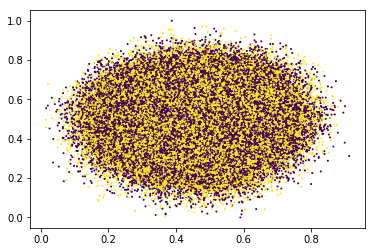

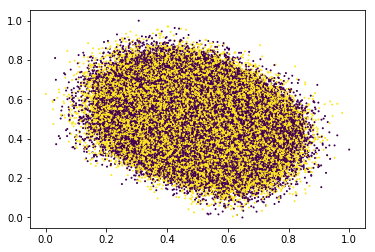

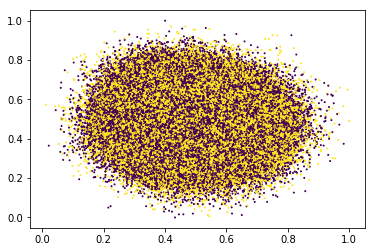

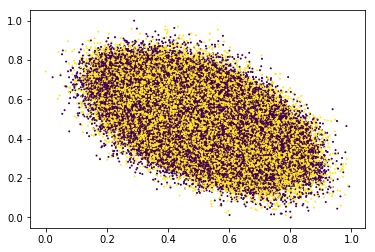

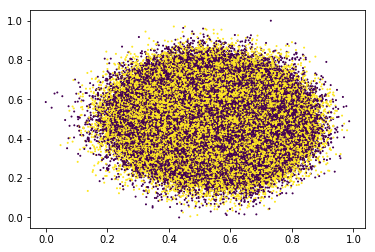

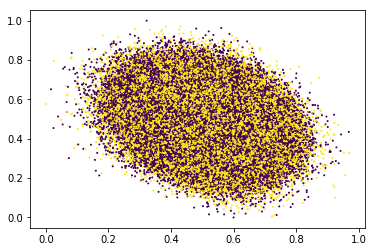

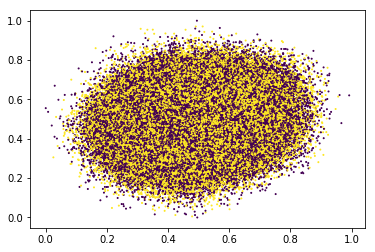

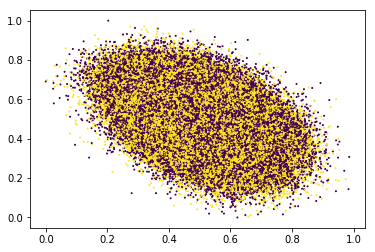

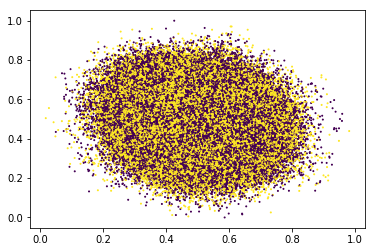

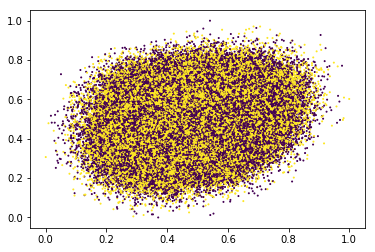

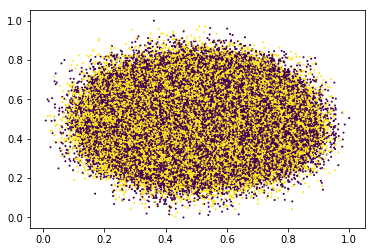

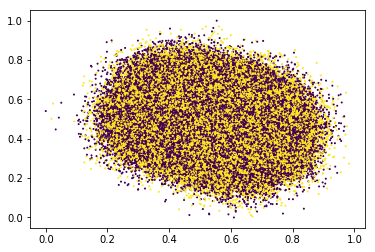

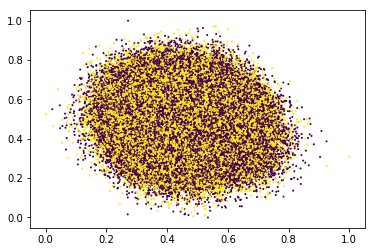

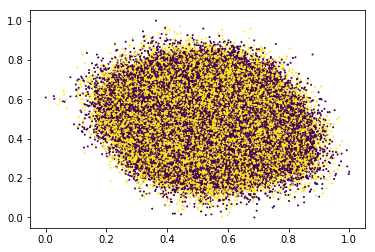

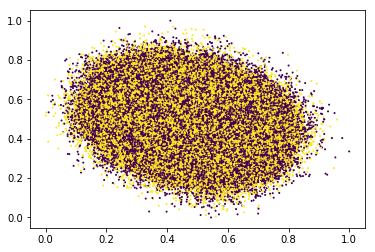

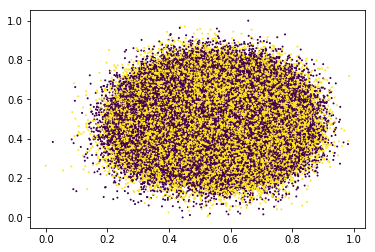

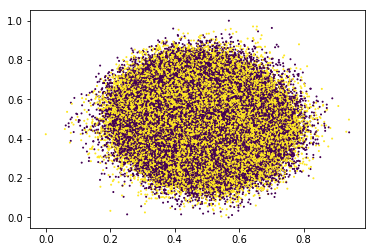

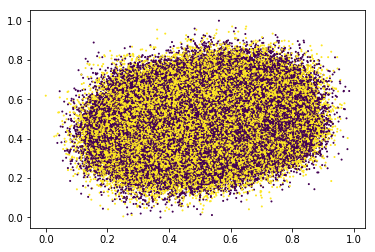

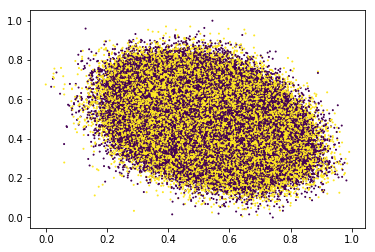

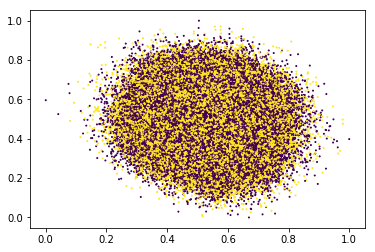

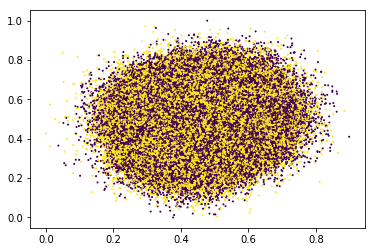

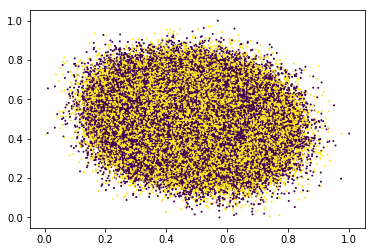

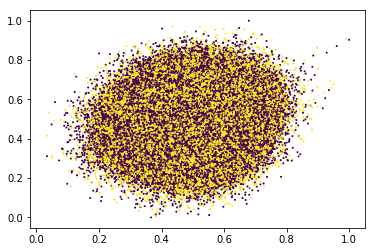

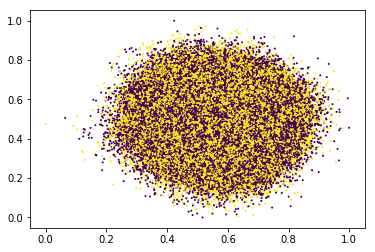

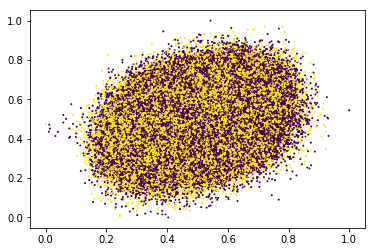

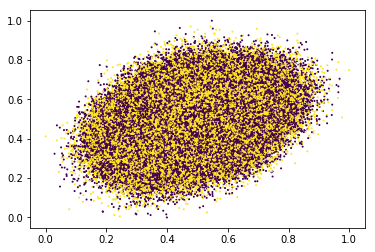

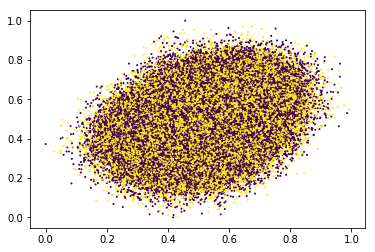

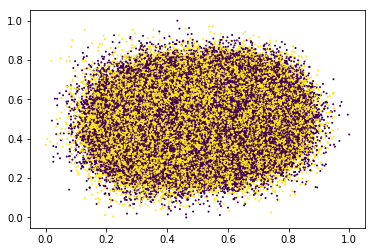

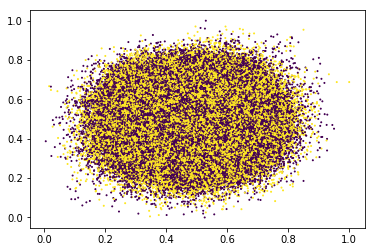

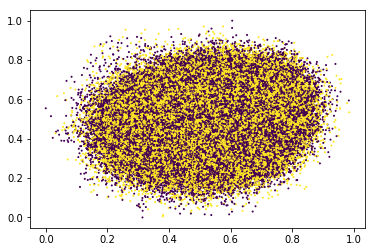

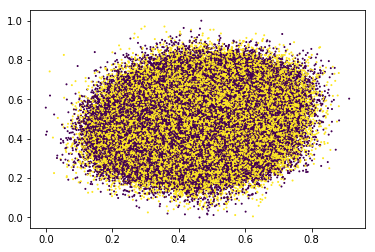

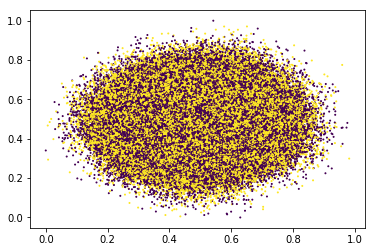

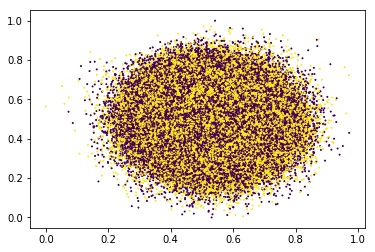

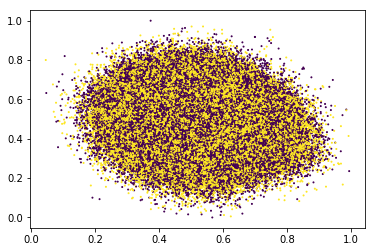

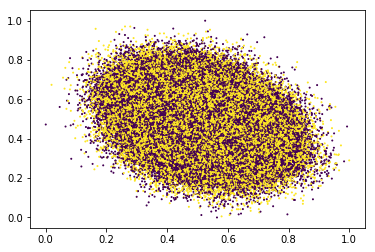

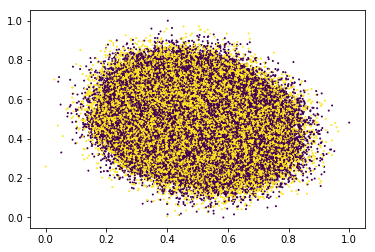

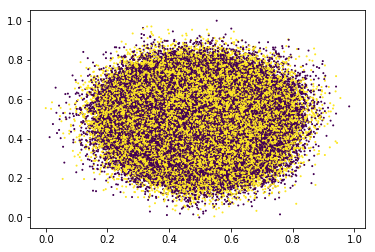

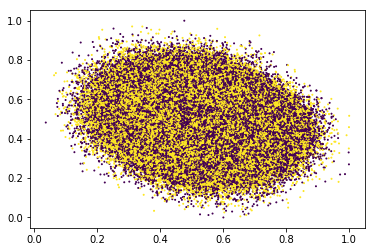

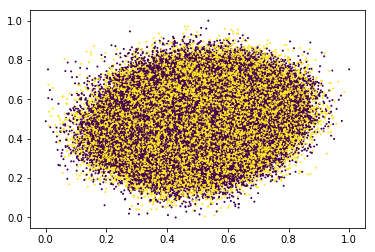

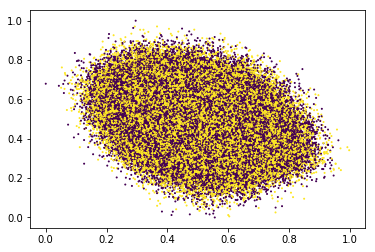

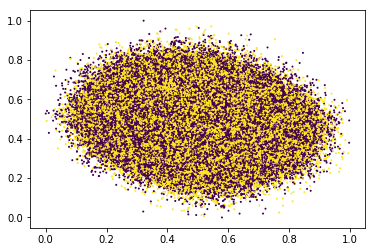

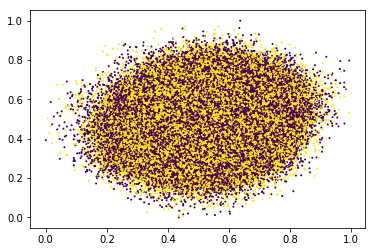

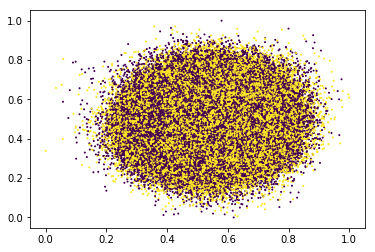

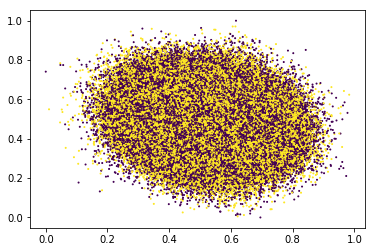

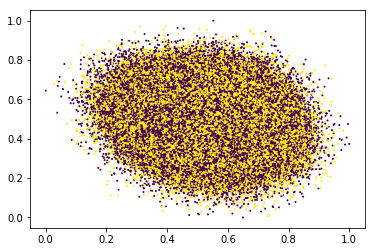

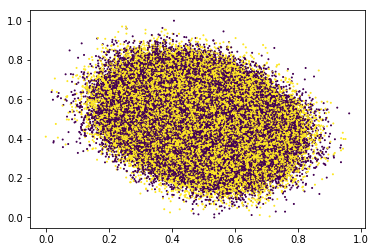

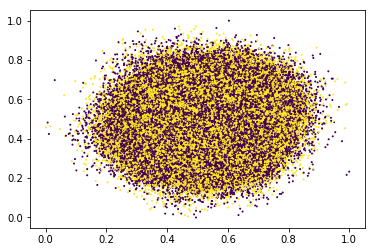

In [126]:
for i in range(4,51):
    plt.scatter(X["feature"+str(i)],X["feature"+str(3)],s=1,c=Y)
    plt.show()

In [127]:
train = pd.read_csv('numerai_training_data.csv', header=0)

In [134]:
train=train[train['era']=='era1']
train=train.iloc[:100,:]

In [161]:
np.mean(X)

feature1          0.467463
feature2          0.457734
feature3          0.481866
feature4          0.444961
feature5          0.509518
feature6          0.484868
feature7          0.524472
feature8          0.558369
feature9          0.517500
feature10         0.469235
feature11         0.518194
feature12         0.497087
feature13         0.489780
feature14         0.506731
feature15         0.540536
feature16         0.457506
feature17         0.518136
feature18         0.476602
feature19         0.539164
feature20         0.483003
feature21         0.522624
feature22         0.540096
feature23         0.532446
feature24         0.455382
feature25         0.503964
feature26         0.494822
feature27         0.567138
feature28         0.480337
feature29         0.462148
feature30         0.512339
                    ...   
feature45**17     0.712176
feature45_17           inf
feature45_l_17         NaN
feature45**43     0.728518
feature45_43           inf
feature45_l_43         inf
f